In [16]:
import argparse
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn

from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from model import VGGStyleDiscriminator128

from datetime import datetime
import matplotlib.pyplot as plt


In [17]:
now = datetime.now()

DAY_TIME = now.strftime("%d-%m-%Y_%H:%M:%S")
MODEL_NAME = 'JPEG_CLASSIFICATION'

CROP_SIZE = 128
BATCH_SIZE = 64
UPSCALE_FACTOR = 2
QUALITY_FACTOR = 20
NUM_EPOCHS = 20

In [18]:
torch.autograd.set_detect_anomaly(True)

train_set = TrainDatasetFromFolder('data/DIV2K_train_HR', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR, quality_factor=QUALITY_FACTOR)
# val_set = ValDatasetFromFolder('data/DIV2K_valid_HR', upscale_factor=UPSCALE_FACTOR, quality_factor=QUALITY_FACTOR)
val_set = TrainDatasetFromFolder('data/DIV2K_valid_HR', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR, quality_factor=QUALITY_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)


[showing training images]: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


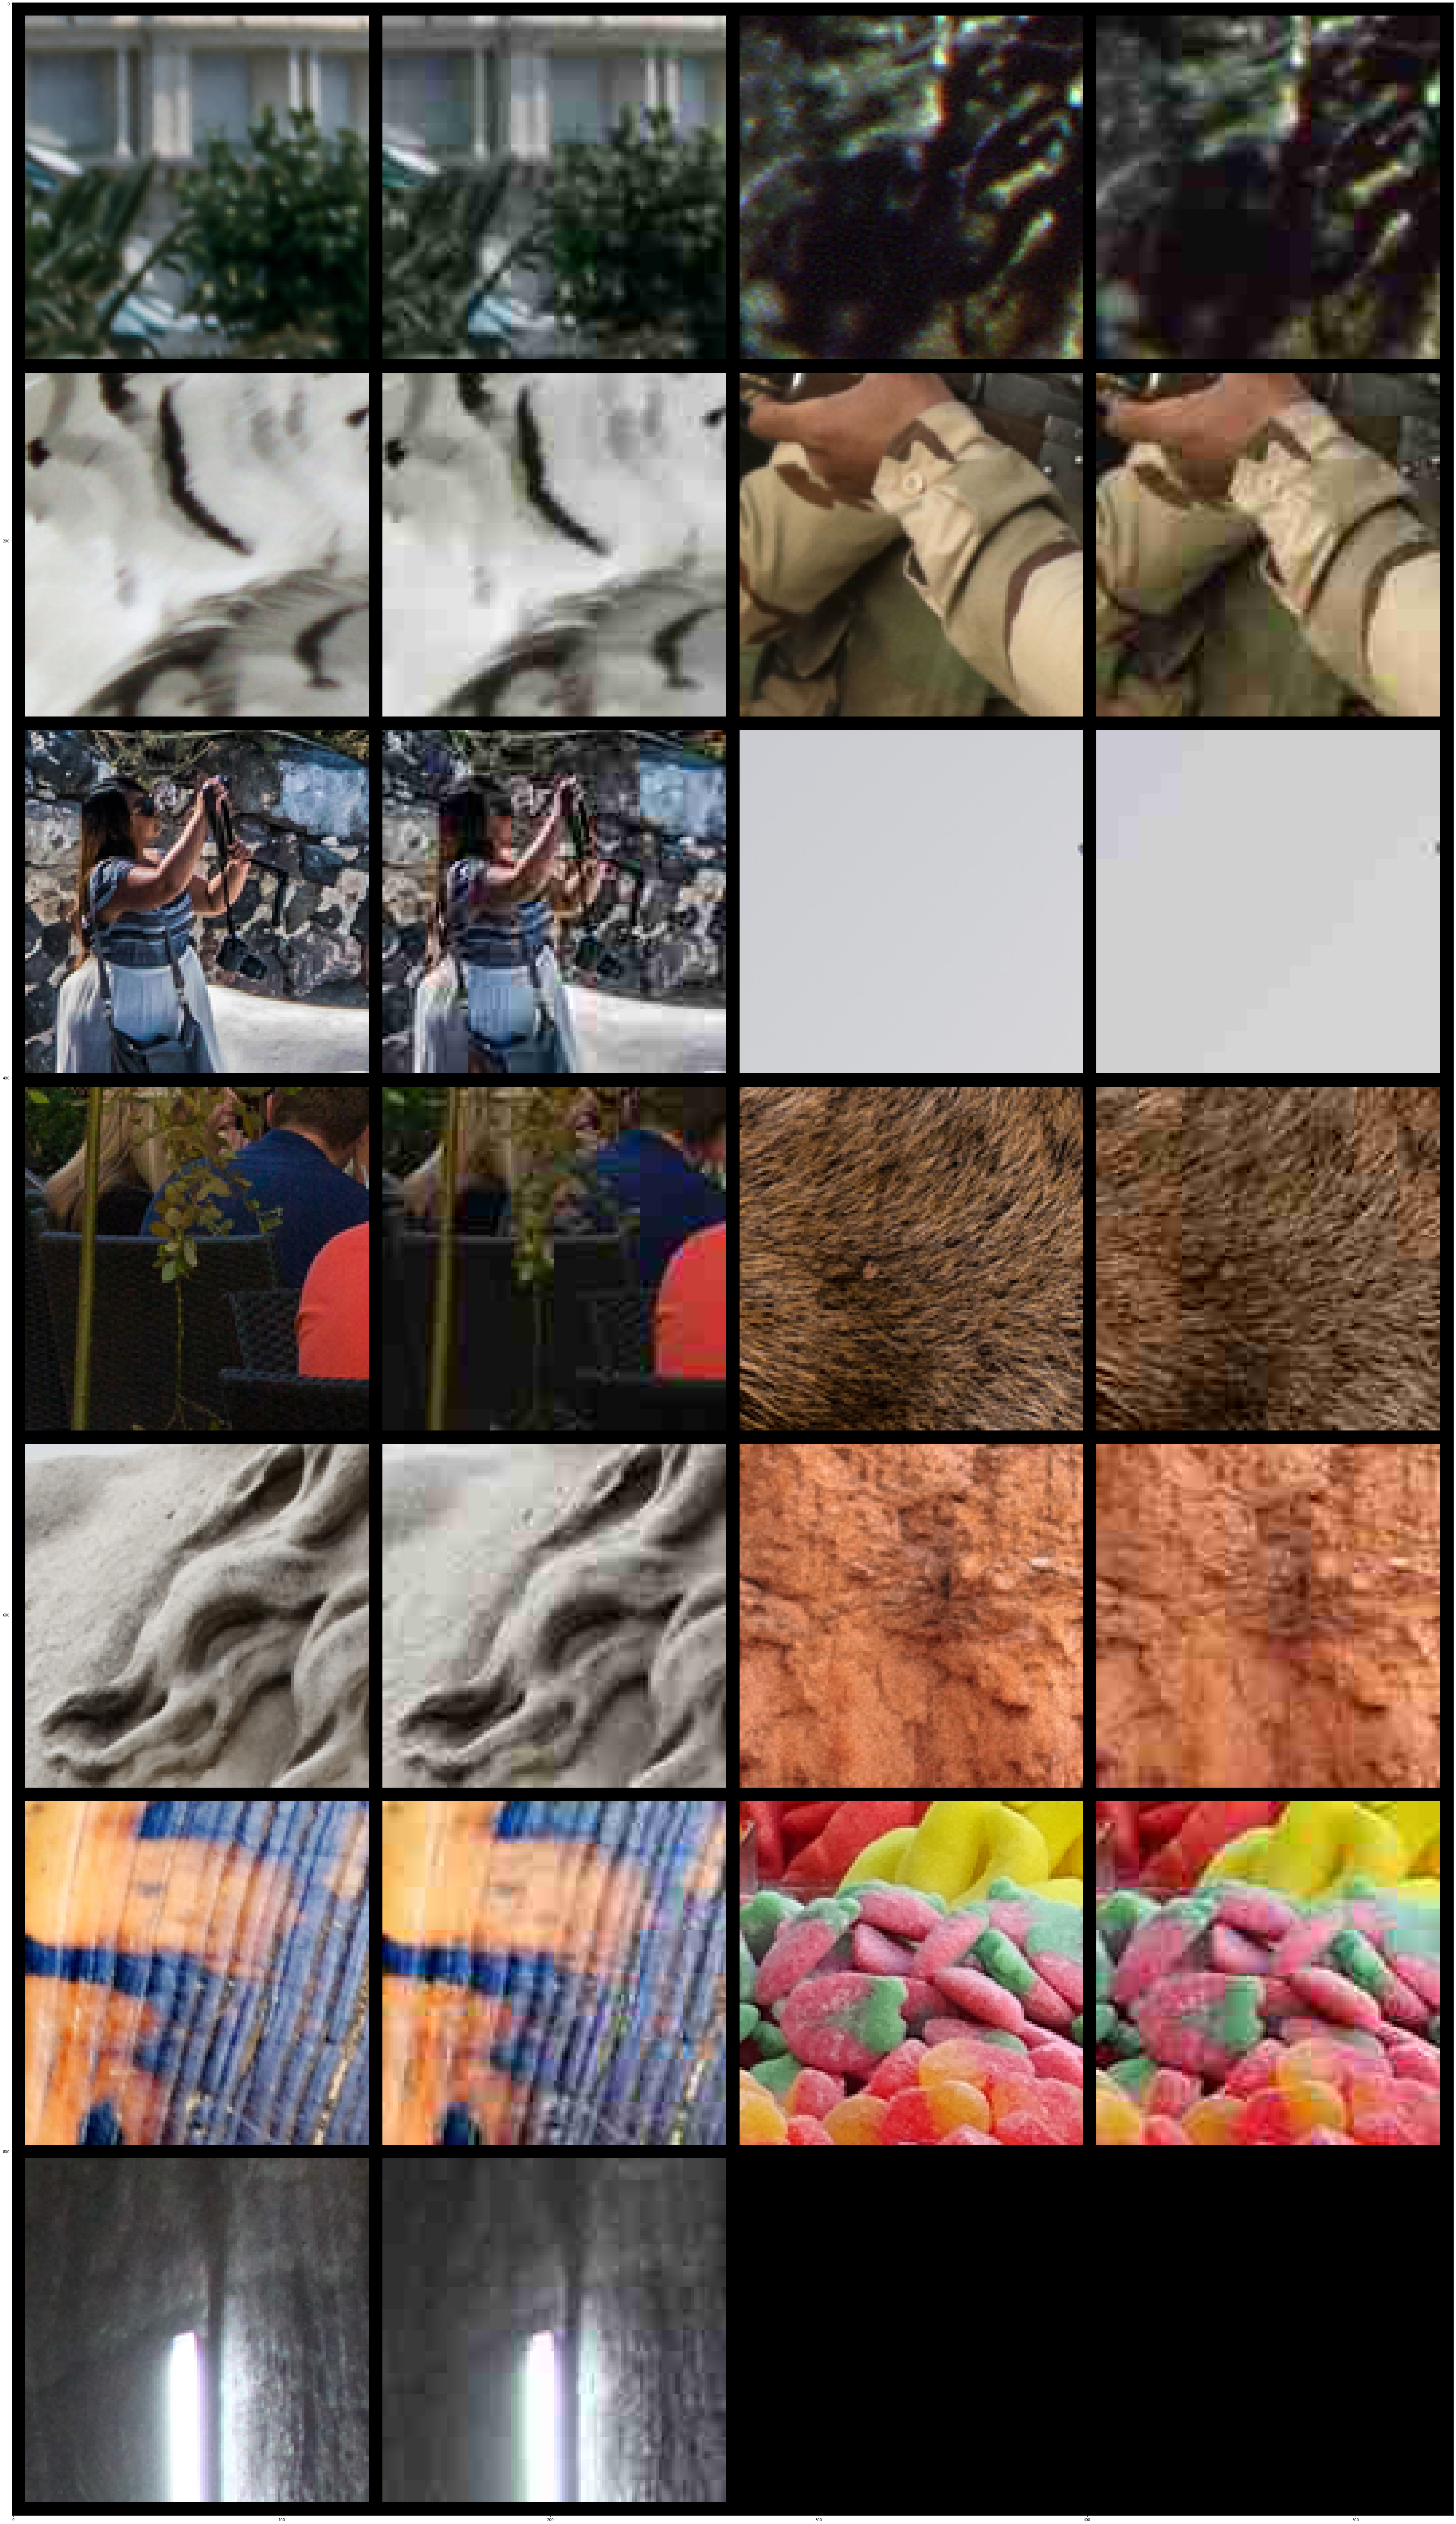

In [19]:
train_bar = tqdm(train_loader)

train_images = []
for jpeg, target in train_bar:

    real_img = Variable(target)
    fake_img = Variable(jpeg)
    
    train_images.extend([display_transform()(real_img[0].data.squeeze(0)), display_transform()(fake_img[0].data.squeeze(0))])

# show images (train)
train_images = torch.stack(train_images)
train_images = torch.chunk(train_images, train_images.size(0) // 15)
train_show_bar = tqdm(train_images, desc='[showing training images]')

index = 1
for image in train_show_bar:
    image = utils.make_grid(image, nrow=4, padding=5)

    plt.figure(figsize = (128,128))
    plt.imshow(image.permute(1, 2, 0))
    
    index += 1

[showing validation images]: 100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


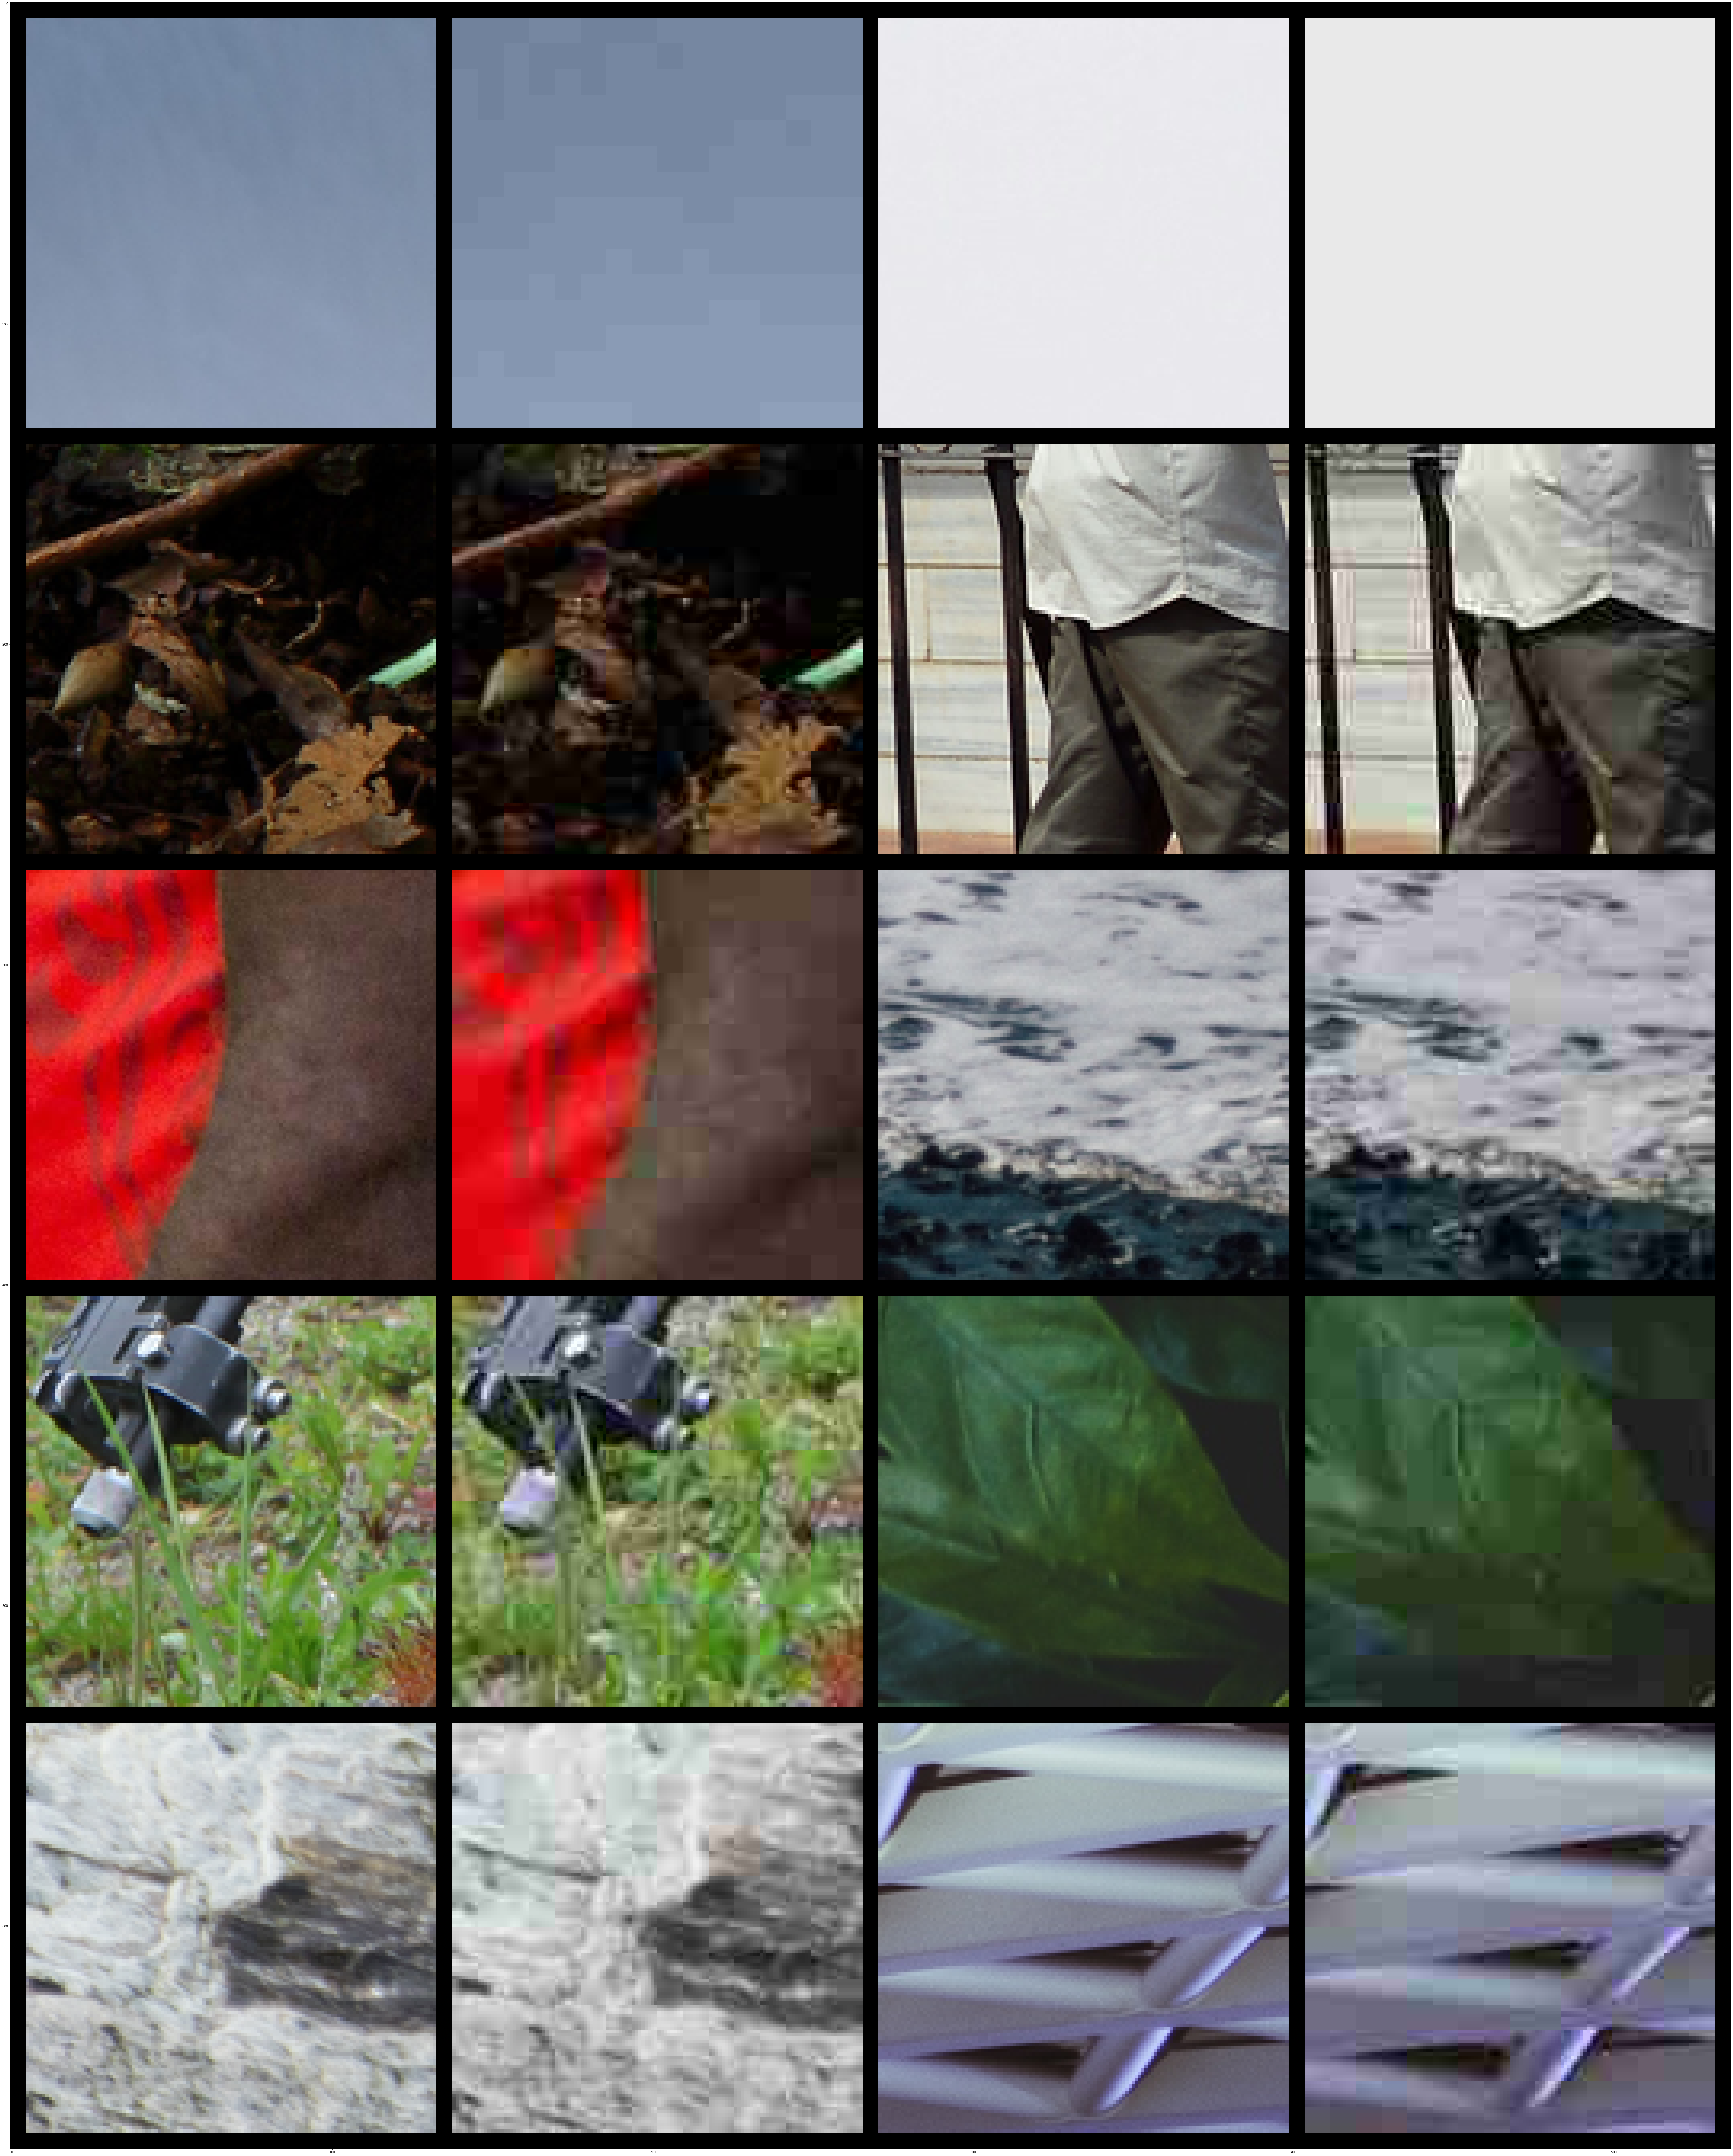

In [20]:
val_bar = tqdm(val_loader)

val_images = []
for i, (jpeg, target) in enumerate(val_bar):

    real_img = Variable(target)
    fake_img = Variable(jpeg)
    
    if i % 10 == 0:
        val_images.extend([display_transform()(real_img[0].data.squeeze(0)), display_transform()(fake_img[0].data.squeeze(0))])

# show images (validation)
val_images = torch.stack(val_images)
val_images = torch.chunk(val_images, val_images.size(0) // 15)
val_show_bar = tqdm(val_images, desc='[showing validation images]')

index = 1
for image in val_show_bar:
    image = utils.make_grid(image, nrow=4, padding=5)

    plt.figure(figsize = (128,128))
    plt.imshow(image.permute(1, 2, 0))
    
    index += 1

In [21]:
netD = VGGStyleDiscriminator128(num_out=1)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))
    


# discriminator parameters: 14499401


In [22]:
discriminator_criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    netD.cuda()
    discriminator_criterion.cuda()

discriminator_optimizer = optim.Adam(netD.parameters())

    

In [23]:
results = { 'TRAIN_d_loss': [], 'TRAIN_real_score': [], 'TRAIN_jpeg_score': [],
                'VAL_d_loss': [], 'VAL_real_score': [], 'VAL_jpeg_score': [] }
    
pre_path = 'results_' + MODEL_NAME + '/'

file_name = 'run'+str(DAY_TIME) + '_crop'+str(CROP_SIZE) + '_batch'+str(BATCH_SIZE) + '_upscale'+str(UPSCALE_FACTOR) + '_qf'+str(QUALITY_FACTOR) + '_epochs'+str(NUM_EPOCHS)
        

    

In [24]:
for epoch in range(1, NUM_EPOCHS + 1):

    print('\n')

    train_bar = tqdm(train_loader)

    running_results = {'batch_sizes': 0, 'd_loss': 0, 'real_score': 0, 'jpeg_score': 0}

    netD.train()
    for jpeg, target in train_bar:

        batch_size = target.size(0)
        running_results['batch_sizes'] += batch_size

        discriminator_optimizer.zero_grad()
        
        real_img = Variable(target)
        fake_img = Variable(jpeg)
                        
        if torch.cuda.is_available():
            real_img = real_img.cuda()
            fake_img = fake_img.cuda()
        
        real_out = netD(real_img)
        fake_out = netD(fake_img)
        
        output = torch.cat((real_out, fake_out), 0).view(-1)

        labels_ones = torch.ones([batch_size, 1], dtype=torch.float32)
        labels_zero = torch.zeros([batch_size, 1], dtype=torch.float32)
        labels = torch.cat((labels_ones, labels_zero), 0).view(-1)

        if torch.cuda.is_available():
            output = output.cuda()
            labels = labels.cuda()
        
        d_loss = discriminator_criterion(output, labels)
        d_loss.backward()
        discriminator_optimizer.step()
        
        # loss for current batch before optimization 
        running_results['d_loss'] += d_loss.item() * batch_size
        

        running_results['real_score'] += torch.sigmoid(real_out).mean().item() * batch_size
        running_results['jpeg_score'] += torch.sigmoid(fake_out).mean().item() * batch_size
        

        train_bar.set_description(desc='[%d/%d] (TRAIN) Loss_D: %.4f D(x): %.4f D(Jpeg(x)): %.4f' % (
            epoch, NUM_EPOCHS, 
            running_results['d_loss'] / running_results['batch_sizes'],
            running_results['real_score'] / running_results['batch_sizes'],
            running_results['jpeg_score'] / running_results['batch_sizes']))

    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'batch_sizes': 0, 'd_loss': 0, 'real_score': 0, 'jpeg_score': 0}

        for val_jr, val_hr in val_bar:

            batch_size = val_jr.size(0)
            valing_results['batch_sizes'] += batch_size
            
            val_real_img = Variable(val_hr)
            val_fake_img = Variable(val_jr)
                        
            if torch.cuda.is_available():
                val_real_img = val_real_img.cuda()
                val_fake_img = val_fake_img.cuda()
            
            val_real_out = netD(val_real_img)
            val_fake_out = netD(val_fake_img)
            
            val_output = torch.cat((val_real_out, val_fake_out), 0).view(-1)

            val_labels_ones = torch.ones([batch_size, 1], dtype=torch.float32)
            val_labels_zero = torch.zeros([batch_size, 1], dtype=torch.float32)
            val_labels = torch.cat((val_labels_ones, val_labels_zero), 0).view(-1)

            if torch.cuda.is_available():
                val_output = val_output.cuda()
                val_labels = val_labels.cuda()
            
            val_d_loss = discriminator_criterion(val_output, val_labels)
            
            # loss for current batch before optimization 
            valing_results['d_loss'] += val_d_loss.item() * batch_size

            valing_results['real_score'] += torch.sigmoid(val_real_out).mean().item() * batch_size
            valing_results['jpeg_score'] += torch.sigmoid(val_fake_out).mean().item() * batch_size
            
            val_bar.set_description(desc='[%d/%d] (VAL) Loss_D: %.4f D(x): %.4f D(Jpeg(x)): %.4f' % (
                epoch, NUM_EPOCHS, 
                valing_results['d_loss'] / valing_results['batch_sizes'],
                valing_results['real_score'] / valing_results['batch_sizes'],
                valing_results['jpeg_score'] / valing_results['batch_sizes']))

    # ? save model parameters
    # torch.save(netD.state_dict(), pre_path + 'epochs/run%s_crop%d_batch%d_upscale%d_qf%d_epoch%d_netD.pth' % (DAY_TIME, CROP_SIZE, BATCH_SIZE, UPSCALE_FACTOR, QUALITY_FACTOR, epoch))
    
    results['TRAIN_d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['TRAIN_real_score'].append(running_results['real_score'] / running_results['batch_sizes'])
    results['TRAIN_jpeg_score'].append(running_results['jpeg_score'] / running_results['batch_sizes'])

    results['VAL_d_loss'].append(valing_results['d_loss'] / valing_results['batch_sizes'])
    results['VAL_real_score'].append(valing_results['real_score'] / valing_results['batch_sizes'])
    results['VAL_jpeg_score'].append(valing_results['jpeg_score'] / valing_results['batch_sizes'])

    # save loss\scores
    if epoch % 2 == 0 and epoch != 0:
        out_path = pre_path + 'statistics/'
        data_frame = pd.DataFrame(
            data={
                'TRAIN_Loss_D': results['TRAIN_d_loss'],
                'TRAIN_Score_Real': results['TRAIN_real_score'], 
                'TRAIN_Score_Jpeg': results['TRAIN_jpeg_score'],
                'VAL_Loss_D': results['VAL_d_loss'],
                'VAL_Score_Real': results['VAL_real_score'], 
                'VAL_Score_Jpeg': results['VAL_jpeg_score']
            },
            index=range(1, epoch + 1))
        data_frame.to_csv(out_path + file_name + '_train_results.csv', index_label='Epoch')


  0%|          | 0/13 [00:00<?, ?it/s]

[1/20] (TRAIN) Loss_D: 0.8811 D(x): 0.4744 D(Jpeg(x)): 0.4744: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]
[1/20] (VAL) Loss_D: 0.7339 D(x): 0.4339 D(Jpeg(x)): 0.4364: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]
  0%|          | 0/13 [00:00<?, ?it/s]

[2/20] (TRAIN) Loss_D: 0.7015 D(x): 0.5079 D(Jpeg(x)): 0.5079: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it]
[2/20] (VAL) Loss_D: 0.7054 D(x): 0.4679 D(Jpeg(x)): 0.4681: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]
  0%|          | 0/13 [00:00<?, ?it/s]

[3/20] (TRAIN) Loss_D: 0.6961 D(x): 0.5038 D(Jpeg(x)): 0.5037: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it]
[3/20] (VAL) Loss_D: 0.6983 D(x): 0.4964 D(Jpeg(x)): 0.4984: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]
  0%|          | 0/13 [00:00<?, ?it/s]

[4/20] (TRAIN) Loss_D: 0.6942 D(x): 0.5024 D(Jpeg(x)): 0.5022: 100%|██████████| 13/13 [00:26<00:00,  2.06s/it]
[4/20] (VAL) Loss_D: 0.6951 D(x): 0.4939 D(Jpeg(x)): 0.4942: 10